In [18]:
import typing as t
import itertools
import json

import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
from scipy.stats import zscore
from matplotlib import pyplot as plt

Read input file directly from GCS

In [2]:
input_file = 'gs://pipelines-hackathon/input_data/yahoo_stock.csv'

In [3]:
df = pd.read_csv(input_file, parse_dates=['Date'], index_col='Date')

In [4]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
...,...,...,...,...,...,...
2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912
2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029
2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039


# Plot the data
Show training-validation-test split with background color

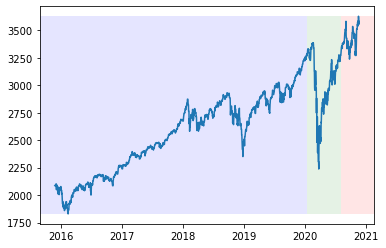

In [5]:
plt.plot(df.index, df.Close)
plt.axhspan(df.Close.min(), df.Close.max(), 0, 0.8, facecolor='blue', alpha=0.1)
plt.axhspan(df.Close.min(), df.Close.max(), 0.8, 0.9, facecolor='green', alpha=0.1)
plt.axhspan(df.Close.min(), df.Close.max(), 0.9, 1.0, facecolor='red', alpha=0.1)

# Normalize the numerical values

In [6]:
normalized_df = df.apply(zscore)

In [7]:
normalized_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,-1.379765,-1.364247,-1.371535,-1.378390,-0.259034,-1.378390
2015-11-24,-1.383403,-1.391708,-1.383794,-1.372128,0.014075,-1.372128
2015-11-25,-1.386138,-1.352099,-1.371805,-1.372791,-0.935061,-1.372791
2015-11-26,-1.386138,-1.352099,-1.371805,-1.372791,-0.935061,-1.372791
2015-11-27,-1.385430,-1.357468,-1.372984,-1.369746,-2.209876,-1.369746
...,...,...,...,...,...,...
2020-11-16,2.362953,2.393231,2.339849,2.404417,1.298961,2.404417
2020-11-17,2.349769,2.364829,2.364784,2.361735,0.855282,2.361735
2020-11-18,2.339953,2.312009,2.369157,2.259227,1.292035,2.259227


# Assign train-validation-test split

In [8]:
normalized_df['subset'] = pd.qcut(normalized_df.index, q=[.0, .8, .9, 1.], labels=['train', 'val', 'test'])

# Dump data as tfrecord files

In [9]:
def get_historical_samples(subset: str, history_size: int = 5) -> t.Iterable[t.Tuple[pd.DataFrame, pd.Series]]:
    return filter(
        # only take given subset of samples
        lambda past_current: past_current[1].subset == subset,
        map(
            # split into historical data and cucrrent row
            lambda df: (df.iloc[:-1], df.iloc[-1]),
            # rolling window of constant size
            filter(
                lambda df: len(df) >= history_size + 1,
                normalized_df.rolling(window=history_size + 1)
            )
        )
    )

In [10]:
def _float_feature(value: float) -> tf.train.Feature:
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [11]:
def _float_list_feature(values: t.Iterable[float]) -> tf.train.Feature:
    return tf.train.Feature(float_list=tf.train.FloatList(value=list(values)))

In [12]:
def _int64_feature(value: int) -> tf.train.Feature:
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [13]:
def _string_encode(value: str) -> bytes:
    assert value
    return value.encode("utf-8")

def _string_feature(value: str) -> tf.train.Feature:
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[_string_encode(value)])
    )

In [14]:
def serialize_example(past_rows: pd.DataFrame, current_row: t.Dict[str, t.Any]) -> bytes:
    features = {
        'past_high': _float_list_feature(past_rows['High']),
        'past_low': _float_list_feature(past_rows['Low']),
        'past_open': _float_list_feature(past_rows['Open']),
        'past_close': _float_list_feature(past_rows['Close']),
        'past_volume': _float_list_feature(past_rows['Volume']),
        'past_adj_close': _float_list_feature(past_rows['Adj Close']),
        'open': _float_feature(current_row['Open']),
        'close': _float_feature(current_row['Close']),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=features))
    message: bytes = example_proto.SerializeToString()
    return message

Store output directly to GCS

In [15]:
for subset in tqdm(['train', 'val', 'test']):
    with tf.io.TFRecordWriter(f'gs://pipelines-hackathon/preprocessed_data/yahoo_stock.{subset}.tfrecord') as writer:
        for past_rows, current_row in get_historical_samples(subset, history_size=30):
            example = serialize_example(past_rows, current_row)
            writer.write(example)

  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
def serialize_example_json(past_rows: pd.DataFrame, current_row: t.Dict[str, t.Any]) -> str:
    example = {
        'past_high': list(past_rows['High']),
        'past_low': list(past_rows['Low']),
        'past_open': list(past_rows['Open']),
        'past_close': list(past_rows['Close']),
        'past_volume': list(past_rows['Volume']),
        'past_adj_close': list(past_rows['Adj Close']),
        'open': [current_row['Open']],
    }
    return json.dumps(example)

In [24]:
for subset in tqdm(['train', 'val', 'test']):
    with tf.io.gfile.GFile(f'gs://pipelines-hackathon/preprocessed_data/yahoo_stock.{subset}.jsonl', 'w') as writer:
        for past_rows, current_row in get_historical_samples(subset, history_size=30):
            example = serialize_example_json(past_rows, current_row)
            writer.write(example)
            writer.write('\n')

  0%|          | 0/3 [00:00<?, ?it/s]